READ INPUT FILES...
     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!
Done!
INITIALIZATION...
     -> COMPUTE INITIAL GUESS...Done!
     -> INITIALISE LEVEL-SET...Done!
     -> INITIALISE ELEMENTS...Done!
     -> CLASSIFY ELEMENTS...Done!
     -> INITIALISE ELEMENTAL PHI VALUES...Done!
     -> FIND BOUNDARY EDGES...Done!
     -> COMPUTE BOUNDARY NORMALS...Done!
     -> APPROXIMATE INTERFACE...Done!
     -> COMPUTE INTERFACE NORMALS...Done!
     -> COMPUTE NUMERICAL INTEGRATION QUADRATURES...Done!
     -> COMPUTE INITIAL VACUUM VESSEL BOUNDARY VALUES PHI_B...Done!
Done!
START ITERATION...
OUTER ITERATION = 1 , INNER ITERATION = 1
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/src/GradShafranovCutFEM.py:1354: UserWarning: No contour levels were found within the data range.
  axs[0].tricontour(self.X[:,0],self.X[:,1], Jphi, levels=[0], colors = 'black')
/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/src/GradShafranovCutFEM.py:1361: UserWarning: No contour levels were found within the data range.
  axs[1].tricontour(self.X[:,0],self.X[:,1], self.PHI_NORM[:,1], levels=[0], colors = 'black')


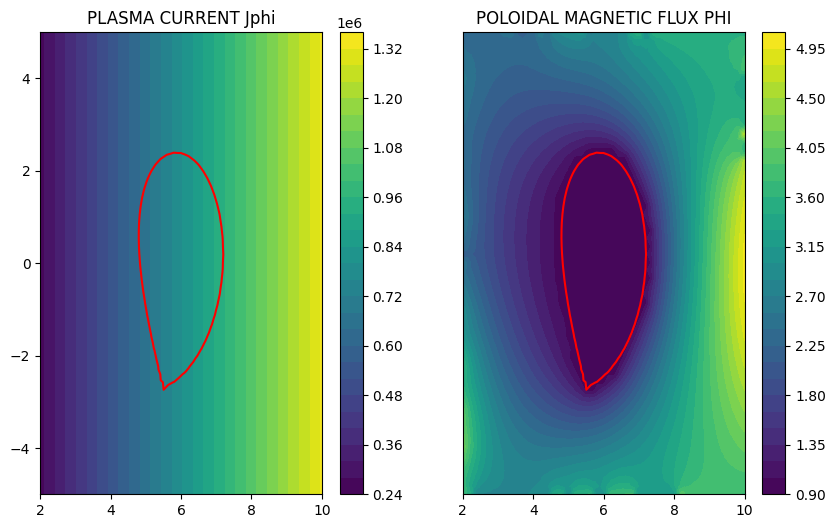

OUTER ITERATION = 1 , INNER ITERATION = 2
     Assemble non-cut elements...Done!
     Assemble cut elements...Done!


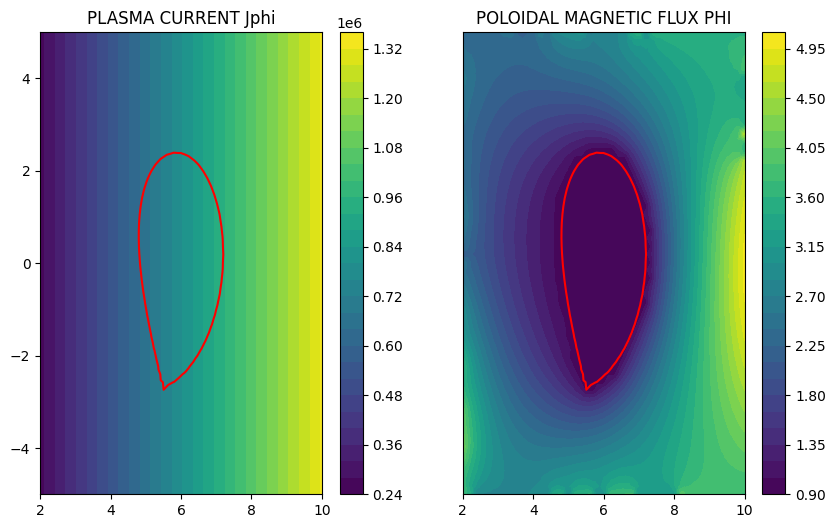

SOLUTION CONVERGED


In [1]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
#MESH = 'TS-UNSTRUCTURED_ULTRACOARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE-FINE'
MESH = 'TS-UNSTRUCTURED_FINE'
#MESH = 'TS-UNSTRUCTURED_ULTRAFINE'

# ... WITH MESH ELEMENTS:
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 1    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
CASE = 'TS-FREE-F4E-LINEAR'          # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT
#CASE = 'TS-FREE-F4E-PROFILES'        # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
#CASE = 'TS-FREE-F4E-LINEAR-1W'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, LINEAR PLASMA CURRENT AND FIRST WALL VACUUM VESSEL GEOMETRY  
#CASE = 'TS-FREE-F4E-PROFILES-1W'     # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD AND FIRST WALL VACUUM VESSEL GEOMETRY  

# SELECT ORDER OF NUMERICAL INTEGRATION QUADRATURE
QuadratureOrder = 2

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder,QuadratureOrder)

Problem.EQUILI()


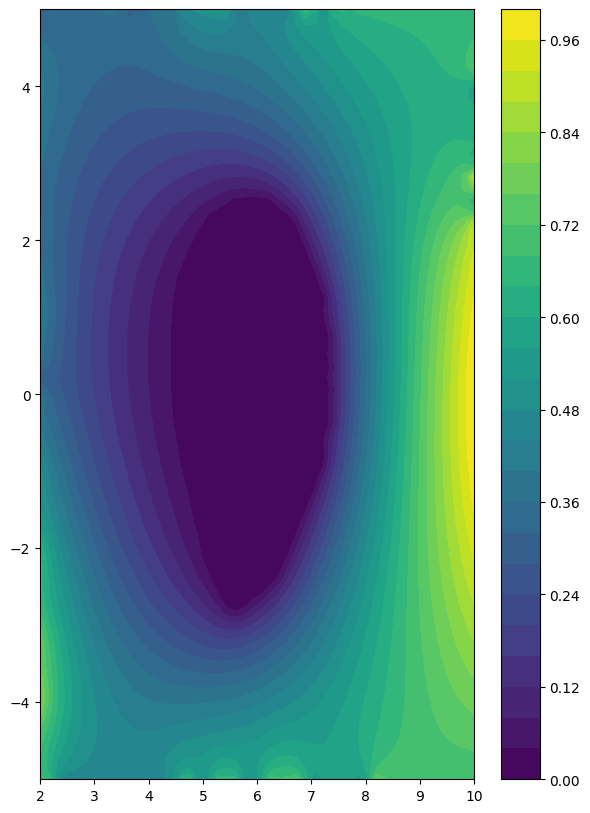

In [66]:
self = Problem
PHI = self.PHI

# 1. INTERPOLATE PHI VALUES ON A FINER STRUCTURED MESH USING PHI ON NODES
# DEFINE FINER STRUCTURED MESH
Mr = 50
Mz = 70
rfine = np.linspace(np.min(self.X[:,0]), np.max(self.X[:,0]), Mr)
zfine = np.linspace(np.min(self.X[:,1]), np.max(self.X[:,1]), Mz)
# INTERPOLATE PHI VALUES
Rfine, Zfine = np.meshgrid(rfine,zfine)
PHIfine = griddata((self.X[:,0],self.X[:,1]), PHI.T[0], (Rfine, Zfine), method='cubic')

# NORMALISE
PHIfine = (PHIfine-np.min(PHIfine))/(np.max(PHIfine)-np.min(PHIfine))

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,PHIfine,levels = 30)
plt.colorbar()

[47, 23]


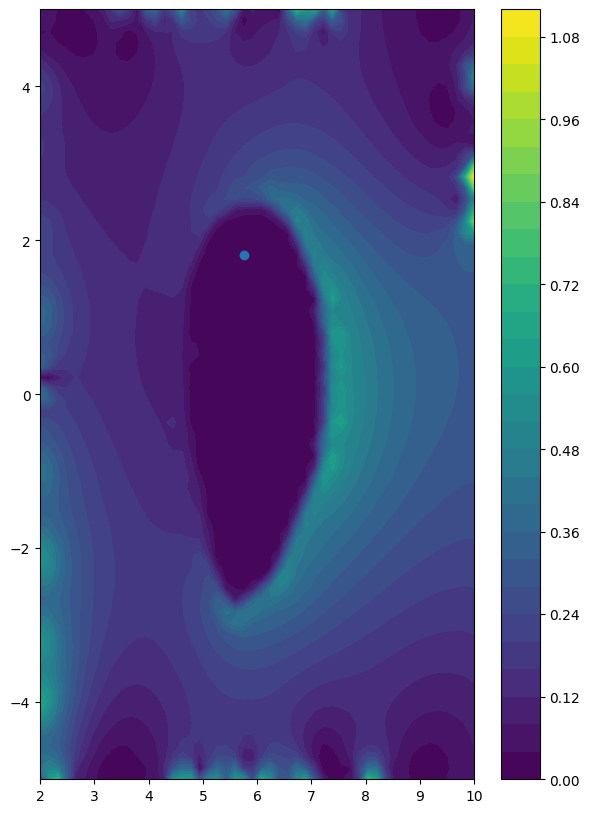

In [67]:
# 2. COMPUTE GRAD(PHI) WITH FINER MESH VALUES USING FINITE DIFFERENCES
dr = (rfine[-1]-rfine[0])/Mr
dz = (zfine[-1]-zfine[0])/Mz
gradPHIfine = np.gradient(PHIfine,dr,dz)
NORMgradPHIfine = np.zeros(np.shape(gradPHIfine)[1:])
for i in range(Mr):
    for j in range(Mz):
        NORMgradPHIfine[j,i] = np.linalg.norm(np.array([gradPHIfine[0][j,i],gradPHIfine[1][j,i]])) 

minpos = np.where(NORMgradPHIfine == np.min(NORMgradPHIfine))
minpos = [minpos[0][0],minpos[1][0]]

print(minpos)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine, levels=30)
plt.plot(rfine[minpos[1]],zfine[minpos[0]],'o')
plt.colorbar()

    fjac: array([[-0.3856643 ,  0.92263917],
       [-0.92263917, -0.3856643 ]])
     fun: array([-9.71266770e-05, -4.07854833e-05])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 38
     qtf: array([-1.71992215e-07,  1.05342382e-04])
       r: array([-2.37070820e-02,  9.19458762e-04,  4.46015384e-06])
  status: 5
 success: False
       x: array([ 6.5816226 , -0.33513532])


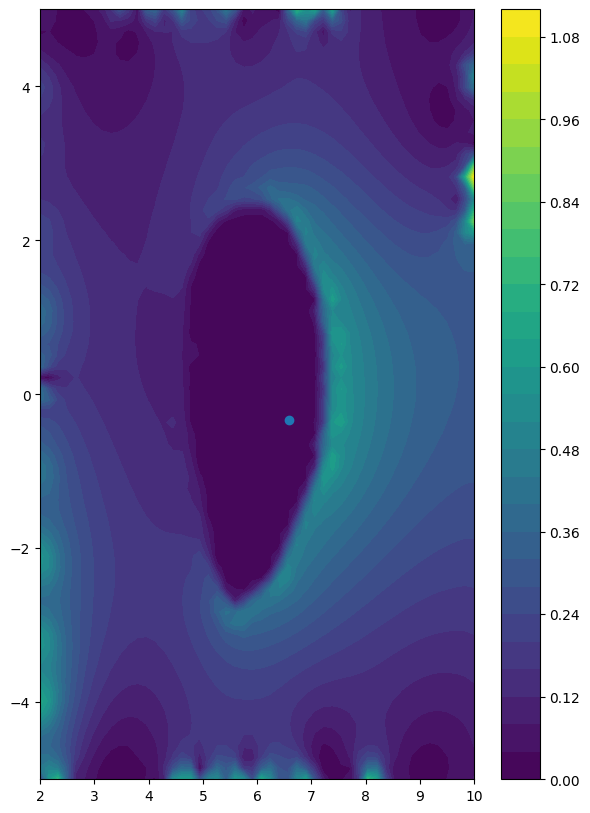

In [68]:
def gradPHI(X,Rfine,Zfine,gradPHIfine):
    dPHIdr = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[0].flatten(), (X[0],X[1]), method='cubic')
    dPHIdz = griddata((Rfine.flatten(),Zfine.flatten()), gradPHIfine[1].flatten(), (X[0],X[1]), method='cubic')
    GRAD = np.array([dPHIdr,dPHIdz])
    return GRAD

X0 = np.array([6,0])
sol = optimize.root(gradPHI, X0, args=(Rfine,Zfine,gradPHIfine))
print(sol)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=30)
plt.plot(sol.x[0],sol.x[1],'o')
plt.colorbar()


1 4.953538888668701e-07
[[6. 0.]]


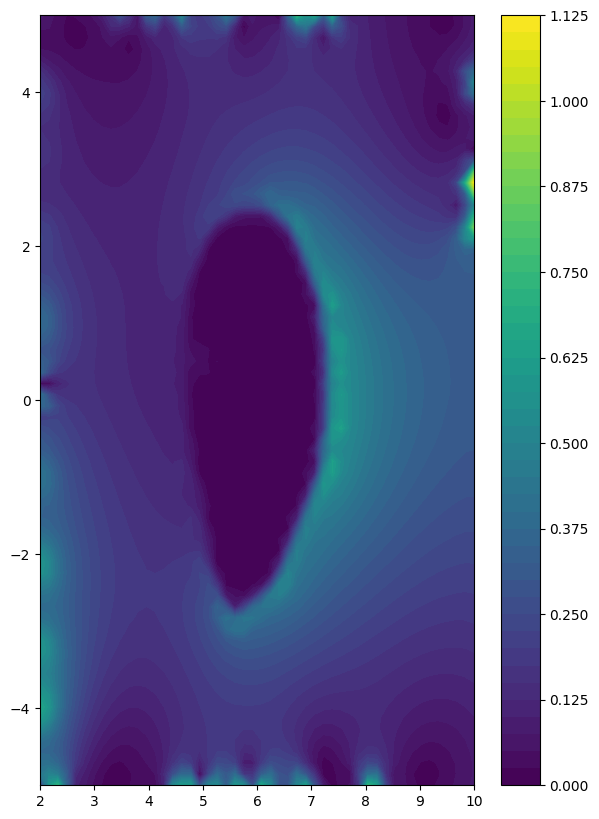

In [69]:
def gradient_descent(gradient, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine):
    Xk = np.zeros([itmax,2])
    it = 0; TOL = 1
    Xk[it,:] = X0
    while TOL > tolerance and it < itmax:
        dX = -alpha * gradient(Xk[it,:], Rfine,Zfine,gradPHIfine)
        Xk[it+1,:] = Xk[it,:]+np.flip(dX)
        TOL = np.linalg.norm(Xk[it+1,:]-Xk[it,:])
        it += 1
    return it, TOL, Xk[:it,:] 

X0 = np.array([6,0])
alpha = 0.0005
itmax = 50; tolerance = 1e-3
it, TOL, Xk = gradient_descent(gradPHI, X0, alpha, itmax, tolerance, Rfine,Zfine,gradPHIfine)

print(it, TOL)
print(Xk)

plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=50)
for i in range(it-1):
    plt.plot([Xk[i,0],Xk[i+1,0]],[Xk[i,1],Xk[i+1,1]],'-o')
plt.colorbar()

In [70]:
# COMPUTE HESSIAN
def EvaluateHESSIAN(X,gradPHIfine,Rfine,Zfine,dr,dz):
    # compute second derivatives on fine mesh
    dgradPHIdrfine = np.gradient(gradPHIfine[0],dr,dz)
    dgradPHIdzfine = np.gradient(gradPHIfine[1],dr,dz)
    # interpolate HESSIAN components on point 
    dPHIdrdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[0].flatten(), (X[0],X[1]), method='cubic')
    dPHIdzdr = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdrfine[1].flatten(), (X[0],X[1]), method='cubic')
    dPHIdzdz = griddata((Rfine.flatten(),Zfine.flatten()), dgradPHIdzfine[1].flatten(), (X[0],X[1]), method='cubic')
    if dPHIdrdr*dPHIdzdz-dPHIdzdr**2 > 0:
        return "Local extremum"
    else:
        return "Saddle point"
    
# Xcrit = Xk[-1,:]
Xcrit = sol.x

EvaluateHESSIAN(Xcrit, gradPHIfine, Rfine, Zfine, dr, dz)

'Saddle point'

(-0.5966679, -0.2234628)

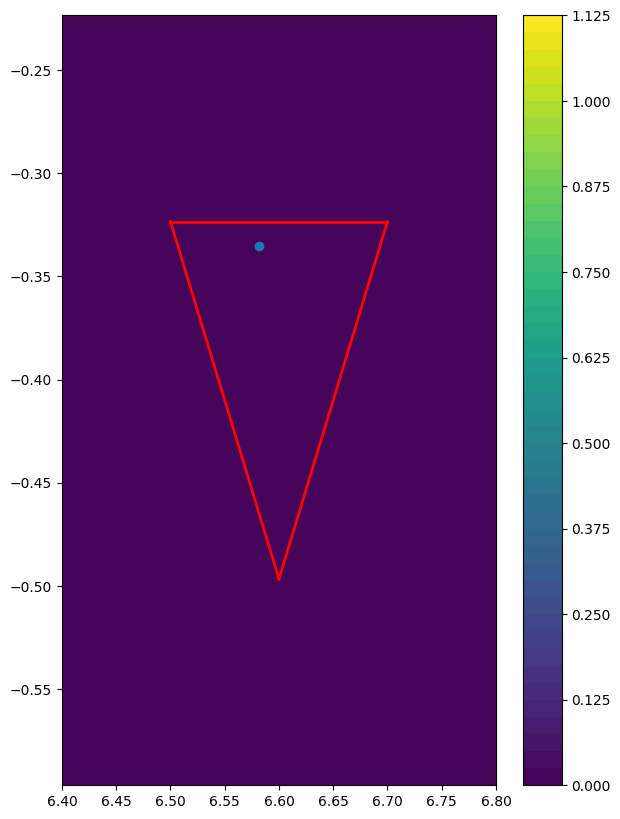

In [71]:
def SearchElement(Problem,X,elements):
    """ Function which finds the element among the elements list containing the point with coordinates X. """
    
    for elem in elements:
        Xe = Problem.Elements[elem].Xe
        # Calculate the cross products (c1, c2, c3) for the point relative to each edge of the triangle
        c1 = (Xe[1,0]-Xe[0,0])*(X[1]-Xe[0,1])-(Xe[1,1]-Xe[0,1])*(X[0]-Xe[0,0])
        c2 = (Xe[2,0]-Xe[1,0])*(X[1]-Xe[1,1])-(Xe[2,1]-Xe[1,1])*(X[0]-Xe[1,0])
        c3 = (Xe[0,0]-Xe[2,0])*(X[1]-Xe[2,1])-(Xe[0,1]-Xe[2,1])*(X[0]-Xe[2,0])
        if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
            break
    return elem

elem = SearchElement(Problem,Xcrit,Problem.PlasmaElems)


plt.figure(figsize=(7,10))
plt.contourf(rfine,zfine,NORMgradPHIfine,levels=50)
plt.plot(Xcrit[0],Xcrit[1],'-o')
ELEMENT = self.Elements[elem]
for i in range(ELEMENT.n):
    plt.plot([ELEMENT.Xe[i,0],ELEMENT.Xe[(i+1)%ELEMENT.n,0]],[ELEMENT.Xe[i,1],ELEMENT.Xe[(i+1)%ELEMENT.n,1]],color='red',linewidth=2)
plt.colorbar()

plt.xlim(np.min(ELEMENT.Xe[:,0])-0.1, np.max(ELEMENT.Xe[:,0])+0.1)
plt.ylim(np.min(ELEMENT.Xe[:,1])-0.1, np.max(ELEMENT.Xe[:,1])+0.1)


In [72]:
# INTERPOLATE PHI VALUE ON CRITICAL POINT

def InterpolateShapeFunctions(X,Xe,Fe,ElementType, ElementOrder):
    """ Interpolate field F on point X using shape functions in element with nodal coordinates Xe. """
    F = 0
    for i in range(len(Xe[:,0])):
        N = ShapeFunctionsPhysical(X, Xe, ElementType, ElementOrder, i+1)
        F += N*Fe[i]
    return F

PHI_0 = InterpolateShapeFunctions(Xcrit,ELEMENT.Xe,PHI[ELEMENT.Te],ELEMENT.ElType, ELEMENT.ElOrder)

print(PHI_0)

[-50179.74771843]


In [74]:
PHI = self.PHI

PHI_0, PHI_X = self.ComputeCriticalPHI(PHI)

print(PHI_0, PHI_X)


5.411110812230313 -0.9607846584533657


ValueError: z array must have same length as triangulation x and y arrays

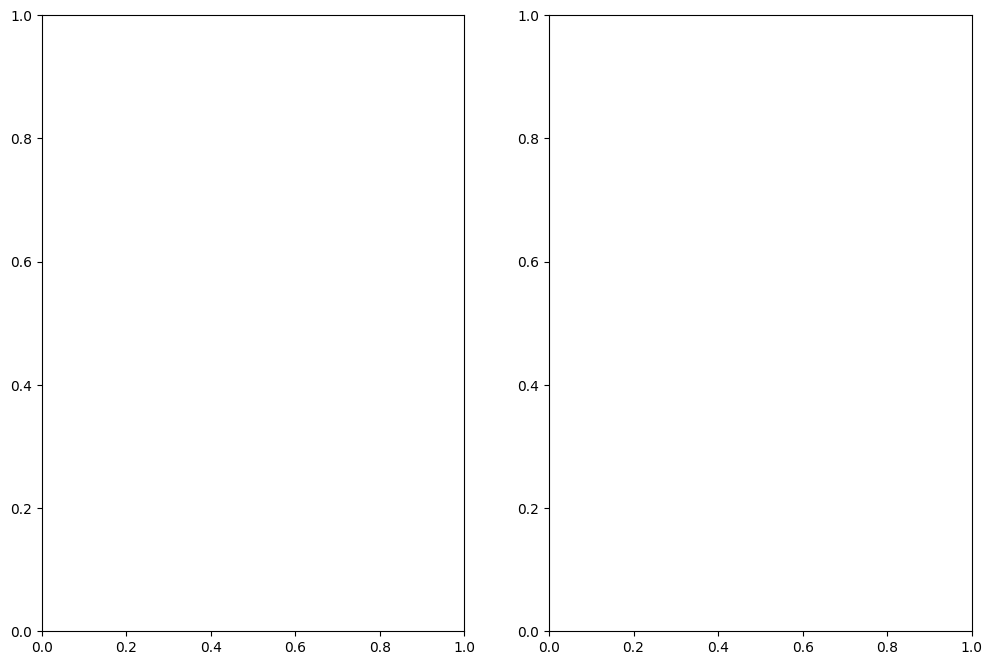

In [75]:

#PHIbar = self.NormalisePHI(PHI,PHI_0,PHI_X)

PHIbar = np.zeros([self.Nn])
for i in range(self.Nn):
    PHIbar[i] = (PHI[i]-PHI_X)/np.abs(PHI_0-PHI_X)
        

fig, axs = plt.subplots(1, 2, figsize=(12,8))
a0 = axs[0].tricontourf(self.X[:,0],self.X[:,1],PHI,levels=50)
plt.colorbar(a0, ax=axs[0])

a1 = axs[1].tricontourf(self.X[:,0],self.X[:,1],PHIbar,levels=50)
plt.colorbar(a1, ax=axs[1])


